<a href="https://colab.research.google.com/github/viraaji/From-Bits-to-Qubits-Quantum-Influence-on-Algorithms/blob/main/Quantum_Computing_PoCs_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installations

In [1]:
!pip install qiskit

In [2]:
!pip install qiskit_ibm_runtime

In [3]:
!pip install pylatexenc

In [4]:
!pip install matplotlib

In [5]:
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram


# Create a Quantum Circuit acting on a quantum register of two qubits
circ = QuantumCircuit(2, 2)

# Add a H gate on qubit 0
circ.h(0)

# Add a CX (CNOT) gate on control qubit 0 and target qubit 1
circ.cx(0, 1)

# Map the quantum measurement to the classical bits
circ.measure([0,1], [0,1])


In [6]:
# Draw the circuit
print(circ.draw())


     ┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1 


Shor’s Algorithm

https://kaustubhrakhade.medium.com/shors-factoring-algorithm-94a0796a13b1

https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/algorithms/shor_algorithm.ipynb



In [7]:
# Brute force period finding algorithm
def find_period_classical(x, N):
    n = 1
    t = x
    while t != 1:
        t *= x
        t %= N
        n += 1
    return n

In [8]:
import random, itertools

# Sieve of Eratosthenes algorithm
def sieve( ):
    D = {  }
    yield 2
    for q in itertools.islice(itertools.count(3), 0, None, 2):
        p = D.pop(q, None)
        if p is None:
            D[q*q] = q
            yield q
        else:
            x = p + q
            while x in D or not (x&1):
                x += p
            D[x] = p

# Creates a list of prime numbers up to the given argument
def get_primes_sieve(n):
    return list(itertools.takewhile(lambda p: p<n, sieve()))

def get_semiprime(n):
    primes = get_primes_sieve(n)
    l = len(primes)
    p = primes[random.randrange(l)]
    q = primes[random.randrange(l)]
    return p*q

N = get_semiprime(1000)

print("semiprime N =",N)

semiprime N = 458581


In [9]:
import math

def shors_algorithm_classical(N):
    x = random.randint(0,N) # step one
    if(math.gcd(x,N) != 1): # step two
        return x,0,math.gcd(x,N),N/math.gcd(x,N)
    r = find_period_classical(x,N) # step three
    while(r % 2 != 0):
        r = find_period_classical(x,N)
    p = math.gcd(x**int(r/2)+1,N) # step four, ignoring the case where (x^(r/2) +/- 1) is a multiple of N
    q = math.gcd(x**int(r/2)-1,N)
    return x,r,p,q

x,r,p,q = shors_algorithm_classical(N)
print("semiprime N = ",N,", coprime x = ",x,", period r = ",r,", prime factors = ",p," and ",q,sep="")

semiprime N = 458581, coprime x = 109434, period r = 76194, prime factors = 458581 and 1


In [10]:
from qiskit import BasicAer, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.tools.visualization import plot_histogram

In [11]:
# qc = quantum circuit, qr = quantum register, cr = classical register, a = 2, 7, 8, 11 or 13
def circuit_amod15(qc,qr,cr,a):
    if a == 2:
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[1],qr[0])
    elif a == 7:
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])
    elif a == 8:
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[3],qr[2])
    elif a == 11: # this is included for completeness
        qc.cswap(qr[4],qr[2],qr[0])
        qc.cswap(qr[4],qr[3],qr[1])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])
    elif a == 13:
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])

In [12]:
# qc = quantum circuit, qr = quantum register, cr = classical register, a = 2, 7, 8, 11 or 13
def circuit_aperiod15(qc,qr,cr,a):
    if a == 11:
        circuit_11period15(qc,qr,cr)
        return

    # Initialize q[0] to |1>
    qc.x(qr[0])

    # Apply a**4 mod 15
    qc.h(qr[4])
    #   controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[0])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a**2 mod 15
    qc.h(qr[4])
    #   controlled unitary
    qc.cx(qr[4],qr[2])
    qc.cx(qr[4],qr[0])
    #   feed forward
    qc.p(math.pi/2.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[1])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a mod 15
    qc.h(qr[4])
    #   controlled unitary.
    circuit_amod15(qc,qr,cr,a)
    #   feed forward
    qc.p(3.*math.pi/4.,qr[4]).c_if(cr, 3)
    qc.p(math.pi/2.,qr[4]).c_if(cr, 2)
    qc.p(math.pi/4.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[2])

In [13]:
def circuit_11period15(qc,qr,cr):
    # Initialize q[0] to |1>
    qc.x(qr[0])

    # Apply a**4 mod 15
    qc.h(qr[4])
    #   controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[0])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a**2 mod 15
    qc.h(qr[4])
    #   controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    #   feed forward
    qc.u1(math.pi/2.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[1])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply 11 mod 15
    qc.h(qr[4])
    #   controlled unitary.
    qc.cx(qr[4],qr[3])
    qc.cx(qr[4],qr[1])
    #   feed forward
    qc.u(3.*math.pi/4.,qr[4]).c_if(cr, 3)
    qc.u(math.pi/2.,qr[4]).c_if(cr, 2)
    qc.u(math.pi/4.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[2])

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


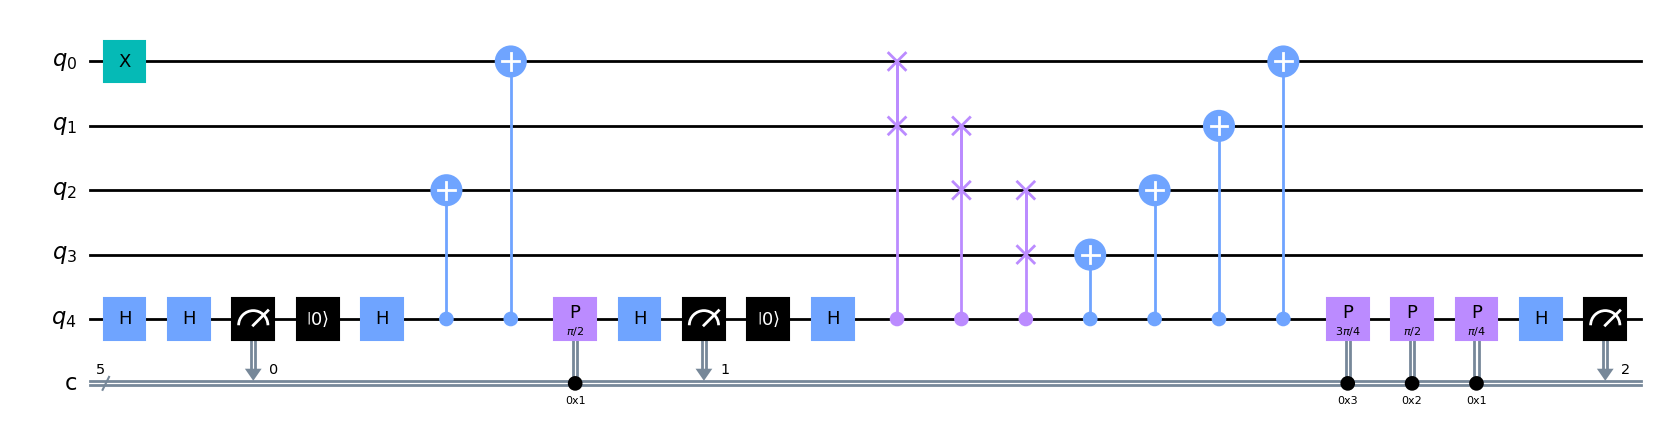

In [14]:
q = QuantumRegister(5, 'q')
c = ClassicalRegister(5, 'c')

shor = QuantumCircuit(q, c)
circuit_aperiod15(shor,q,c,7)
shor.draw(output='mpl')

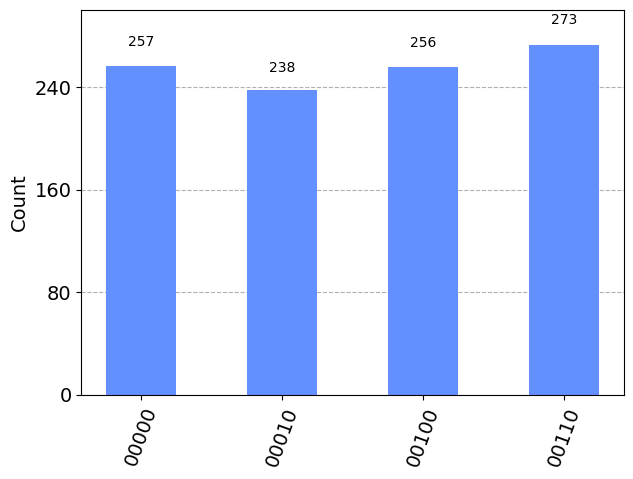

In [15]:
backend = BasicAer.get_backend('qasm_simulator')
sim_job = execute([shor], backend)
sim_result = sim_job.result()
sim_data = sim_result.get_counts(shor)
plot_histogram(sim_data)